In [1]:
%matplotlib widget
import random
import matplotlib.pyplot as plt
from camera import Camera
from dorna2 import Dorna, Kinematic
import numpy as np
import cv2
from ultralytics import YOLO
from paddleocr import PaddleOCR
from IPython.display import display, clear_output
import config
import time
from dorna_vision import util

In [2]:
"""
helper functions
"""
# emergency
def emergency_button_event(msg, union, robot, config):        
    if config.emergency[0] in msg:
        if robot.state == -1 and msg[config.emergency[0]] == config.emergency[1][1]: # init -> stopped
            robot.state = 1
        elif robot.state in [0, 1] and msg[config.emergency[0]] == config.emergency[1][0]: # (stopped, stopping) -> standby -> working
            robot.set_alarm(1) # clear everything first
            robot.state = 2
        elif robot.state in [2, 3] and msg[config.emergency[0]] == config.emergency[1][1]: # (working, standby) -> stopping -> stop
            robot.set_alarm(1) # clear everything first
            robot.state = 0


# classification of bad or good cardamom
def img_classification(results, area_thr=None):
    # init
    cls = -1 # no pick
    good = 0
    
    for result in results:
        if result.masks is not None:
            for i in range(len(result.masks)):
                box = result.boxes[i]
                mask = result.masks.xy[i]
    
                # conver masks to contour
                cnt = np.int32([mask])
                cnt = cnt.reshape(-1, 2)
    
                # check area
                area = cv2.contourArea(cnt)
                if area_thr and area <= min(area_thr) and area >= max(area_thr):
                    continue
                
                # class
                cls_tmp = box.cls.item()
                # adjust the goods
                good += cls_tmp
        
                # one bad found
                if cls_tmp == 0:
                    cls = cls_tmp
                    return cls
    
    # one good at least, otherwise no pick
    if good > 0:
        cls = 1
    
    return cls


# pick a value with highest probability which is also a float number
def weight_classification(results, weight_thr):
    cls = 0
    conf = 0.2
    weight = 0

    # loopp over all the result
    if results[0] is not None:
        for result in results[0]:
            try:
                weight_tmp = float(result[1][0])
                if result[1][1] >= conf:
                    weight = weight_tmp
                    conf = result[1][1]
            except:
                pass
    
        print("weight: ", weight)
        print("resuts: ", weight)
        if weight >= weight_thr:
            cls = 1        
    return cls
    
# pick an item with highest confidence that is within the min and max area, retuen the center of the mass of the detected object
def object_location(crop, robot, kinematic, T_cam_2_j4, camera, depth_frame, depth_int, results,  area_thr, xyz_thr):
    sol = False
    xyz_target_2_base = [0, 0, 0]
    pxl = [0, 0]
    cls = 0
    
    for result in results:
        if result.masks is not None:
            index = list(range(len(result.masks))) 
            random.shuffle(index) # reshuffle
            
            for i in index:
                box = result.boxes[i]
                mask = result.masks.xy[i]

                # class
                cls = box.cls.item()
    
                # conver masks to contour
                cnt = np.int32([mask])
                cnt = cnt.reshape(-1, 2)
    
                # check area
                area = cv2.contourArea(cnt)
                if area <= min(area_thr) or area >= max(area_thr):
                    continue
    
                # center in pixel
                M = cv2.moments(cnt)
                # Calculate centroid (center) of the contour
                pxl = crop.pxl_to_orig([int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])])

                # convert pixel to the original
                # xyz_target to robot
                xyz_target_2_cam, _ = camera.xyz(pxl, depth_frame, depth_int)
                T_target_2_cam = np.eye(4)
                T_target_2_cam[:3, 3] = np.ravel(xyz_target_2_cam)
                
                # current joint and pose
                joint = robot.get_all_joint()
                T_j4_2_base = kinematic.Ti_r_world(i=5, joint=joint[0:6])
                
                # target_2_base
                T_target_2_base = np.matmul(T_j4_2_base, np.matmul(T_cam_2_j4, T_target_2_cam) )
                xyz_target_2_base =T_target_2_base[:3, 3].flatten().tolist()[0] 
    
                # check xyz
                if any([xyz_target_2_base[i] <= min(xyz_thr[i]) or xyz_target_2_base[i] >= max(xyz_thr[i]) for i in range(len(xyz_target_2_base))]):
                    continue
                
                # break the loop
                sol = True
                return cls, xyz_target_2_base, pxl, sol
    
    return cls, xyz_target_2_base, pxl, sol

In [3]:
"""
Initialize model and export it to ncnn formt
"""
# Load a YOLOv8n PyTorch model
model = YOLO(config.trained_model)

# Export the model to NCNN format
exported_model = model.export(format="ncnn")  # creates 'yolov8n_ncnn_model'

# Load the exported NCNN model
net = YOLO(exported_model, task="segment")

# ocr model
ocr = PaddleOCR(use_angle_cls=False, lang='en')  # Disable text orientation classification

Ultralytics YOLOv8.2.51 🚀 Python-3.11.2 torch-2.3.1 CPU (Cortex-A76)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from 'yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 38, 8400), (1, 32, 160, 160)) (6.5 MB)

TorchScript: starting export with torch 2.3.1...
TorchScript: export success ✅ 7.7s, saved as 'yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3.torchscript' (13.0 MB)

NCNN: starting export with NCNN 1.0.20240410...
NCNN: running '/usr/local/lib/python3.11/dist-packages/ultralytics/pnnx yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3.torchscript ncnnparam=yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.ncnn.param ncnnbin=yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.ncnn.bin ncnnpy=yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model_ncnn.py pnnxparam=yolov8n-seg

pnnxparam = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.pnnx.param
pnnxbin = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.pnnx.bin
pnnxpy = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model_pnnx.py
pnnxonnx = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.pnnx.onnx
ncnnparam = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.ncnn.param
ncnnbin = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model.ncnn.bin
ncnnpy = yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model/model_ncnn.py
fp16 = 0
optlevel = 2
device = cpu
inputshape = [1,3,640,640]f32
inputshape2 = 
customop = 
moduleop = 
############# pass_level0
inline module = ultralytics.nn.modules.block.Bottleneck
inline module = ultralytics.nn.modules.block.C2f
inline module = ultralytics.nn.modules.block.DFL
inline module = ultralytics.nn.modules.block.Proto
inline module =

NCNN: export success ✅ 3.5s, saved as 'yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model' (12.6 MB)

Export complete (14.0s)
Results saved to /home/dorna/cardamom
Predict:         yolo predict task=segment model=yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model imgsz=640  
Validate:        yolo val task=segment model=yolov8n-seg_cardamom_good_bad_nano_tile_null_removed_v3_ncnn_model imgsz=640 data=/content/Cardamom-good-bad--24/data.yaml  
Visualize:       https://netron.app
[2024/09/30 10:46:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_siz

In [4]:
"""
Initialize camera, robot and the inverse kinematic engine
"""
# camera on robot
camera_robot = Camera()
print("Camera robot connected: ", camera_robot.connect(serial_number=config.camera_robot_sn, preset_path=config.camera_robot_preset_path, exposure=config.camera_robot_exposure, filter={}))
camera_robot.set_exposure(config.camera_robot_exposure)

# camera ground
camera_ground = Camera()
print("ground connected: ", camera_ground.connect(serial_number=config.camera_ground_sn, preset_path=config.camera_ground_preset_path, filter={}))

# Robot
robot = Dorna()
robot.state = -1 # standby
robot.add_event(target=emergency_button_event, kwargs={"robot": robot, "config": config})
print("Robot connected: ", robot.connect(config.robot_ip))

# kinematics
kinematic = Kinematic(config.robot_model)

Camera robot connected:  True
ground connected:  True
Robot connected:  True


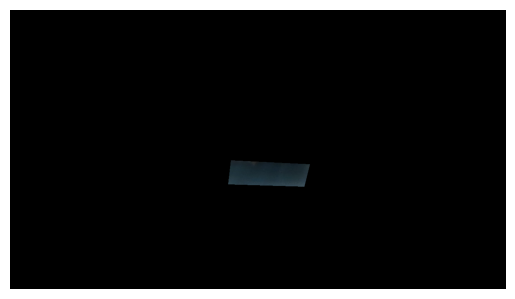

In [ ]:
"""
main loop
"""
start_time = time.time()
tare_counter = config.tare_cycle # number of time an item has been weighted
save_img = 0 # number of images to save
stat = {"try": 0, "picked": 0, "failed":0,  "good":0, "bad":0, "time_passed":0, "avg_time":0} # stat
consecutive_failiure_counter = 0
consecutive_mix = 0
display_result = True # display images or not

while True:
    if robot.state == 0: # stopping -> stopped
        robot.set_alarm(0) # clear alarm
        robot.play_list(cmd_list=config.alarm_init)
        robot.state = 1 # stopped
    
    elif robot.state == 2: # standby -> working
        robot.set_alarm(0) # clear alarm
        robot.play_list(cmd_list=config.work_init)
        robot.state = 3 # stopped

    elif robot.state == 3:
        # update time
        stat["time_passed"] = time.time()-start_time
        stat["avg_time"] = stat["time_passed"] /max(1,stat["picked"])
        print("stat: ", stat)
        
        """
        failed counter
        """
        if consecutive_failiure_counter > config.bin_image_thr and consecutive_mix < config.mix_thr:
            consecutive_failiure_counter = 0 # restart
            robot.play_list(cmd_list=config.bin_mix)
            consecutive_mix += 1 # update consecutive mix
            continue
    
        """
        tare cycle
        """
        if tare_counter >= config.tare_cycle:
            tare_counter = 0
            robot.play_list(cmd_list=config.tare)
            continue
        
        """
        search for candidate
        """
        robot.play_list(cmd_list=config.bin_image) # bin region
        depth_frame, _, _, _, _, color_img, depth_int, _, _= camera_robot.get_all() # camera data
        crop = util.Crop(color_img, config.bin_roi, rot=True)
        color_img_mask = crop.cropped_img
        
        results = net(color_img_mask, half=True, conf=config.detection_conf, max_det=config.max_det, verbose=False) # detection
        cls, xyz_target_2_base, pxl, sol = object_location(crop, robot, kinematic, config.T_cam_2_j4, camera_robot, depth_frame, depth_int, results, config.area_thr, config.xyz_thr) # picking candidate
    
        
        """
        Display
        """
        if display_result:
            # Clear the previous output
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(results[0].plot(boxes=True, masks=False), cv2.COLOR_BGR2RGB)) # Display the image
            plt.axis('off')  # Turn off axis
            display(plt.gcf())  # Display the updated plot
            plt.close() # release the memory
    
        #sol = False
        if not sol: # no candidate
            consecutive_failiure_counter += 1
            continue
        consecutive_failiure_counter = 0 # reset counter
        consecutive_mix = 0 # reset counter
    
        """
        save image
        """
        if save_img > 0: #
            cv2.imwrite("img/"+str(time.time())+".jpg", color_img)
            save_img -= 1
        
        """
        picking
        """
        config.pick[0] = {**config.pick[0], **{"x": xyz_target_2_base[0], "y": xyz_target_2_base[1], "z": xyz_target_2_base[2]+config.tcp_length+8}} # adjust pick xyz
        robot.play_list(cmd_list=config.pick) # pick
        stat["try"] += 1 # update stat
        
        """
        bad after pick
        """
        if cls == 0: # bad
            robot.play_list(cmd_list=config.bad_bin_after_pick) # drop
            stat["bad"] += 1 # update stat
            continue
        
        """
        check successful pick
        """
        robot.play_list(cmd_list=config.quality)
        _, _, _, _, _, color_img, _, _, _= camera_ground.get_all() # camera data
        crop = util.Crop(color_img, config.quality_roi, rot=False)
        successful_pick_img = crop.cropped_img # mask
    
        
        # form one image
        results = net(successful_pick_img, half=True, conf=config.detection_conf, verbose=False) # detection
        cls = img_classification(results, config.area_thr) # quality decision
    
        """
        Display
        """
        if display_result:
            # Clear the previous output
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(results[0].plot(boxes=True, masks=False), cv2.COLOR_BGR2RGB)) # Display the image
            plt.axis('off')  # Turn off axis
            display(plt.gcf())  # Display the updated plot
            plt.close() # release the memory
    
        if cls == -1: # no pick
            stat["failed"] += 1
            continue
        elif cls == 0: # bad
            robot.play_list(cmd_list=config.bad_bin_after_quality) # drop
            stat["picked"] += 1
            stat["bad"] += 1
            continue
    
        """
        quality check: multi bottom
        """
        if config.quality_more["multi_bottom"]:
            # takes 4 images
            color_img_mask_list = []
            for j5 in [-30, 30, 90]:
                robot.jmove(rel=0, j5=j5, vel=250, accel=4000, jerk=10000)
                robot.sleep(0.2)
                _, _, _, _, _, color_img, _, _, _= camera_ground.get_all() # camera data
                crop = util.Crop(color_img, config.quality_roi, rot=False)
                color_img_mask_list.append(crop.cropped_img) # mask
        
            
            # form larger image
            color_img_mask = np.vstack([np.hstack([color_img_mask_list[0], color_img_mask_list[1]]), np.hstack([color_img_mask_list[2], successful_pick_img])])
            results = net(color_img_mask, half=True, conf=config.detection_conf, verbose=False) # detection
            cls = img_classification(results, config.area_thr) # quality decision
    
            """
            Display
            """
            if display_result:
                # Clear the previous output
                clear_output(wait=True)
                plt.imshow(cv2.cvtColor(results[0].plot(boxes=True, masks=False), cv2.COLOR_BGR2RGB)) # Display the image
                plt.axis('off')  # Turn off axis
                display(plt.gcf())  # Display the updated plot
                plt.close() # release the memory
            
            """
            result after quality check
            """
            if cls == -1: # no pick
                stat["failed"] += 1
                continue
            elif cls == 0: # bad
                robot.play_list(cmd_list=config.bad_bin_after_quality) # drop
                stat["picked"] += 1
                stat["bad"] += 1
                continue
    
        """
        quality check_2:second top
        """
        robot.play_list(cmd_list=config.quality_2)
        if config.quality_more["second_top"]:
            # capture data
            _, _, _, _, _, color_img, _, _, _= camera_robot.get_all() # camera data
            crop = util.Crop(color_img, config.quality_2_roi, rot=False)
            color_img_mask = crop.cropped_img
        
            
            # quality check
            results = net(color_img_mask, half=True, conf=config.detection_conf, verbose=False) # detection
            cls = img_classification(results, config.area_thr) # quality decision
    
            """
            Display
            """
            if display_result:
                # Clear the previous output
                clear_output(wait=True)
                plt.imshow(cv2.cvtColor(results[0].plot(boxes=True, masks=False), cv2.COLOR_BGR2RGB)) # Display the image
                plt.axis('off')  # Turn off axis
                display(plt.gcf())  # Display the updated plot
                plt.close() # release the memory
        else:
            cls = 1
        
        if cls != 0:
            """
            weight
            """
            robot.play_list(cmd_list=config.weight)
            
            _, _, _, _, _, color_img, _, _, _= camera_robot.get_all() # camera data
            color_img_mask = util.roi_mask(color_img, config.ocr_roi)
            results = ocr.ocr(color_img_mask, cls=False)  # ocr
            cls = weight_classification(results, config.weight_thr) # classification
            
            """
            Display
            """
            if display_result:
                # Clear the previous output
                clear_output(wait=True)
                plt.imshow(cv2.cvtColor(color_img_mask, cv2.COLOR_BGR2RGB)) # Display the image
                plt.axis('off')  # Turn off axis
                display(plt.gcf())  # Display the updated plot
                plt.close() # release the memory
            
        
        if cls <= 0: # bad
            robot.play_list(cmd_list=config.drop_bad)
            stat["bad"] += 1 #update stat
        else: # good
            robot.play_list(cmd_list=config.drop_good[0:4])
            stat["good"] += 1 #update stat
        
        # increase weight counter
        stat["picked"] += 1 #update stat
        tare_counter += 1 # update stat
    else:
        time.sleep(0.1)


In [ ]:
"""
Always close the camera and robot, once your application is over
"""
# terminate the session
camera_ground.close()
camera_robot.close()
robot.close()

In [3]:
import sys
print(sys.executable)


/usr/bin/python3


In [6]:
import pyrealsense2
#module 'pyrealsense2' has no attribute 'stream'

In [9]:
import pyrealsense2
import inspect

print(inspect.getfile(pyrealsense2))

TypeError: <module 'pyrealsense2' (<_frozen_importlib_external.NamespaceLoader object at 0x7fff30dfe510>)> is a built-in module

In [10]:
import sys

if 'pyrealsense2' in sys.modules:
    print(sys.modules['pyrealsense2'])

<module 'pyrealsense2' (<_frozen_importlib_external.NamespaceLoader object at 0x7fff30dfe510>)>
